In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

eye3_i64 = np.eye(3).astype(np.int64)
mats = [
    np.array(m, dtype=np.int64).reshape(3, 3)
    for m in itertools.product([-1, 0, 1], repeat=9)
]
SO3 = [
    m for m in mats
    if (m @ m.T == eye3_i64).all() and np.linalg.det(m) == 1
]

def recenter(x: np.ndarray) -> np.ndarray:
    return x - x.min(axis=0)

def are_samey(x: np.ndarray, y: np.ndarray) -> bool:
    x = set(map(tuple, recenter(x)))
    y = set(map(tuple, recenter(y)))
    return x == y

def are_alignable(x: np.ndarray, y: np.ndarray) -> bool:
    for a in (x, y):
        assert len(a.shape) == 2
        assert a.shape[1] == 3
    for rot in SO3:
        if are_samey(x, y @ rot):
            return True
    return False

def is_chiral(puzzle_piece: np.ndarray) -> bool:
    return not are_alignable(puzzle_piece, -puzzle_piece)

cardinal_directions = list(eye3_i64) + list(-eye3_i64)

def generate_shapes(so_far, steps):
    if steps == 0:
        yield np.array(so_far)
        return
    for starting_point in so_far:
        for cardinal_direction in cardinal_directions:
            new = starting_point + cardinal_direction
            yield from generate_shapes(so_far + [new], steps-1)

all_shapes = list(generate_shapes([np.array([0, 0, 0], dtype=np.int64)], 5))

In [2]:
len(all_shapes)

933120

In [3]:
all_pentacubes = [
    shape for shape in all_shapes
    if len(set(map(tuple, shape))) == 5
]

In [4]:
len(all_pentacubes)

410652

In [5]:
chiral_pentacubes = [
    pc for pc in tqdm(all_pentacubes)
    if is_chiral(pc)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410652/410652 [00:46<00:00, 8740.24it/s]


In [6]:
equiv_classes = []
for pentacube in tqdm(chiral_pentacubes):
    for equiv_class in equiv_classes:
        if are_alignable(pentacube, equiv_class):
            break
    else:
        equiv_classes.append(pentacube)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129984/129984 [02:04<00:00, 1040.24it/s]


In [7]:
len(equiv_classes)

12

In [8]:
def draw(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    def cube_faces(x, y, z):
        return np.array([
            [[x, y, z], [x+1, y, z], [x+1, y+1, z], [x, y+1, z]],           # bottom face
            [[x, y, z+1], [x+1, y, z+1], [x+1, y+1, z+1], [x, y+1, z+1]],   # top face
            [[x, y, z], [x+1, y, z], [x+1, y, z+1], [x, y, z+1]],           # front face
            [[x, y+1, z], [x+1, y+1, z], [x+1, y+1, z+1], [x, y+1, z+1]],   # back face
            [[x, y, z], [x, y+1, z], [x, y+1, z+1], [x, y, z+1]],           # left face
            [[x+1, y, z], [x+1, y+1, z], [x+1, y+1, z+1], [x+1, y, z+1]]    # right face
        ])
    faces = []
    for (x, y, z) in coords:
        faces.extend(cube_faces(x, y, z))
    ax.add_collection3d(Poly3DCollection(faces,  edgecolors='black', linewidths=1, alpha=0.8))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([np.ptp(coords[:,0])+1, np.ptp(coords[:,1])+1, np.ptp(coords[:,2])+1])
    ax.set_xlim(coords[:,0].min(), coords[:,0].max() + 1)
    ax.set_ylim(coords[:,1].min(), coords[:,1].max() + 1)
    ax.set_zlim(coords[:,2].min(), coords[:,2].max() + 1)
    plt.show()

In [10]:
mirror_pairs = []
for cpc in equiv_classes:
    for existing in mirror_pairs:
        if len(existing) == 1:
            if are_alignable(existing[0], -cpc):
                existing.append(cpc)
                break
    else:
        mirror_pairs.append([cpc])

In [13]:
# We now reorient each pair to be as maximal on the X axis as possible, and minimal on the Z axis.
def optimize(shape):
    def score(s):
        # Spread out along X as much as possible.
        x_extent = s.max(axis=0)[0]
        # Minimize total potential.
        potential = s.sum(axis=0)[2]
        return 1000 * x_extent - potential
    options = [recenter(shape @ r) for r in SO3]
    return max(options, key=score)

Pair:


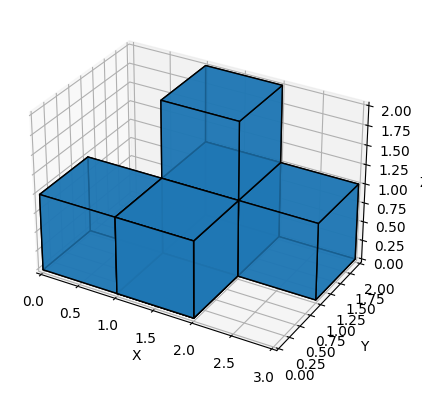

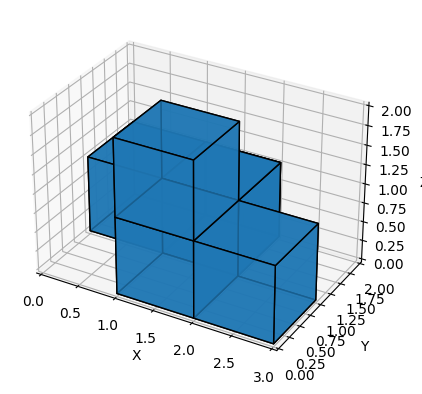

Pair:


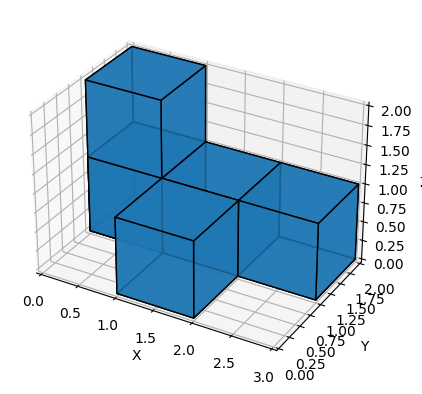

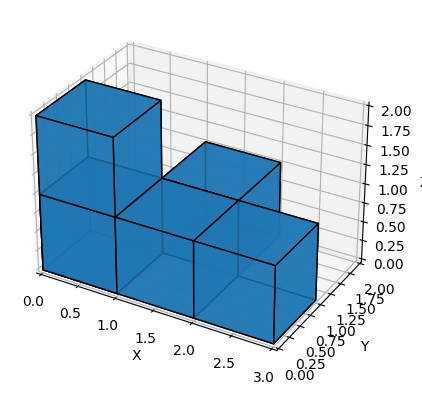

Pair:


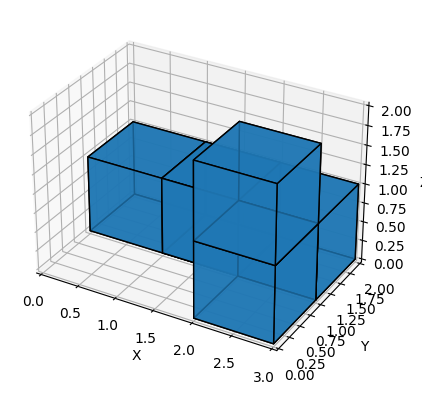

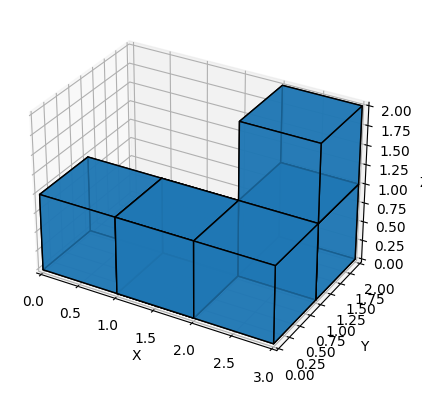

Pair:


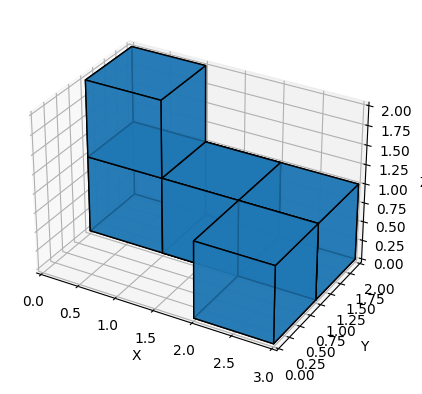

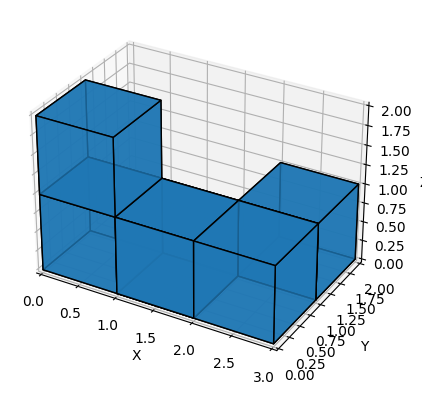

Pair:


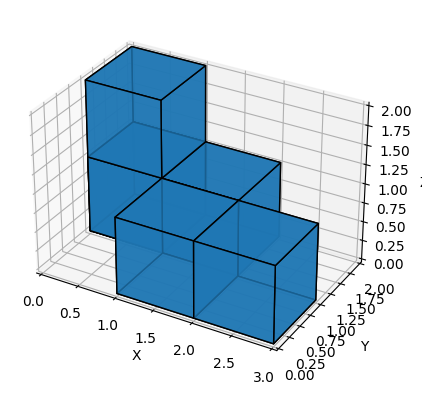

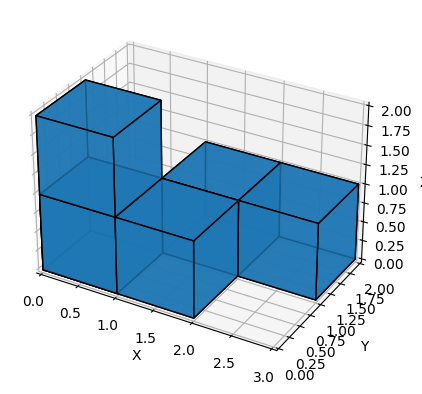

Pair:


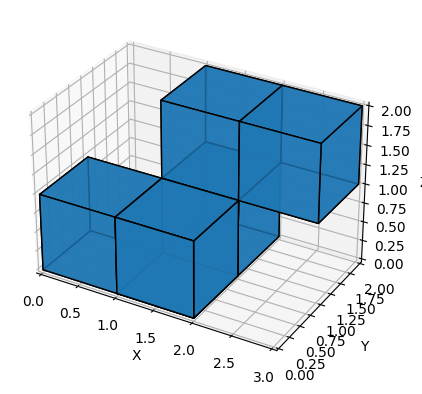

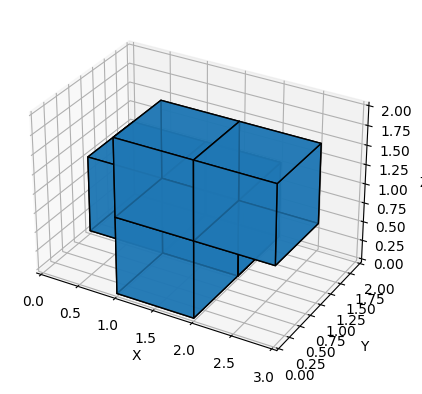

In [17]:
flip_y = np.diag([1, -1, 1])
final = [
    [optimize(pair[0]), recenter(optimize(pair[0]) @ flip_y)]
    for pair in mirror_pairs
]
for pair in final:
    print("Pair:")
    draw(pair[0])
    draw(pair[1])